In [1]:
import json
import os
from backTrans.baidu_trans import backTrans as bt
import backTrans.baidu_trans
import json
from time import sleep
from tqdm import tqdm
from utils.utils import read_json_to_dataframe, write_dataframe_to_json 
import seaborn as sns
import matplotlib.pyplot as plt
from utils.preprocessor import Preprocessor
import pandas as pd

In [2]:
fail_path = 'backTrans/failFiles'
succ_path = 'backTrans/succFiles'
paths = [fail_path, succ_path]

In [3]:
for p in paths:
    d = os.listdir(p)
    print(p,len(d))

backTrans/failFiles 2240
backTrans/succFiles 98896


In [4]:
98896 + 2240

101136

## deal with fail Files

In [4]:
def get_num(p):
    return int(p[0:-5])

d = os.listdir(fail_path)
d = list(map(get_num,d))
d.sort()

In [ ]:
file_path = 'data/train/doc_quality_data_train.json'
ERROR = 'ERROR'
n = 0
with open(file_path, 'r') as f:
    for idx, line in enumerate(f):
        if idx > 101136:
            break
        if not idx in d:
            continue
        n += 1
        l = json.loads(line)
        q = l['body'].replace('\n', '#|#|#')
        s, re1, re2 = bt(q)
        if s == ERROR:
            with open('backTrans/temp/{}.json'.format(idx), 'w') as fail_f:
                json.dump([idx, l['id'], re1, re2], fail_f)
                print("WRONG with ", idx)
        else:
            with open('./succFiles/{}.json'.format(idx), 'w') as succ_f:
                json.dump([idx, l['id'], re1, re2], succ_f)
        print(f'\r {n}/{len(d)}', end = '')
        sleep(1.5)



## build dataset


In [48]:
def read_succ_file(p):
    try:
        l = json.load(open(p,'r'))
        id = l[1]
        src = l[2]['trans_result'][0]['src'].replace('#|#|#','\n')
        dst = l[3]['trans_result'][0]['dst'].replace('#|#|#','\n')
    except:
        return ERROR
    return {'id':id,'src':src,'dst':dst}

In [49]:
def get_num(p):
    return int(p[0:-5])

d = os.listdir(succ_path)
d = list(map(get_num,d))
d.sort()

In [50]:
ERROR = 'ERROR'
p = succ_path + '/' + '{}.json'
f_path = 'data/train/back_trans.json'
with open(f_path,'w') as f:
    for i in tqdm(d):
        c = read_succ_file(p.format(i))
        if c != ERROR:
            json.dump(c,f)
            f.write('\n')


100%|██████████| 98900/98900 [01:34<00:00, 1045.20it/s]


## read the dataset


In [3]:
f_path = 'data/train/back_trans.json'
d = read_json_to_dataframe(f_path)

In [4]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98027 entries, 0 to 98026
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      98027 non-null  object
 1   src     98027 non-null  object
 2   dst     98027 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


In [55]:
d.head()

,id,src,dst
0,0e7668c6-a98d-11eb-8239-7788095c0b0f,篮球——CBA第四阶段：辽宁本钢迎战吉林九台农场银行 \n新华社照片，诸暨（浙江），2021...,篮球-CBA第四阶段：辽宁本溪钢铁对阵吉林九台农场银行新华社照片，诸暨（浙江），2021年3...
1,0e766c68-a98d-11eb-8239-7788095c0b0f,这4种家电，有人相见恨晚，有人感觉鸡肋，主要是价格不一样同样一个产品，口碑却两极分化。感觉好...,有些人讨厌在这四种家电中相逢太晚，有些人觉得鸡排主要是因为价格不同，但同一产品的声誉是两极分...
2,0e766e70-a98d-11eb-8239-7788095c0b0f,PEHCHAOLIN 百雀羚 肌初赋活系列肌初赋活护肤套装聚划算折后单价283元，喜欢的值友...,Pehchaolin Baique muscle initial activation系列肌...
3,0e766fd8-a98d-11eb-8239-7788095c0b0f,XTEP 特步男鞋运动鞋男夏季透气2020年新品男士休闲鞋潮流老爹鞋男潮鞋特步男鞋运动鞋男夏...,XTEP special男鞋运动鞋男式夏季透气2020新款男式休闲鞋潮流dad's shoe...
4,0e7671cc-a98d-11eb-8239-7788095c0b0f,冲3连红，NBA预测：马刺VS鹈鹕，众星缺阵，鹈鹕迎来好机会凯尔特人118:112步行者，昨...,NBA预测，在明星缺席的情况下，马刺队对鹈鹕队将有一个很好的机会。凯尔特人118:112步行...


In [5]:
d['l_src'] = d.src.apply(lambda x: len(x))

In [6]:
d['l_dst'] = d.dst.apply(lambda x:len(x))

In [7]:
d['r'] = d.l_dst/d.l_src

In [9]:
d.r.quantile([0.9+i*0.01 for i in range(10)])

0.90    1.103271
0.91    1.114858
0.92    1.128571
0.93    1.145403
0.94    1.165414
0.95    1.192661
0.96    1.225806
0.97    1.275874
0.98    1.351351
0.99    1.621556
Name: r, dtype: float64

In [10]:
d.r.quantile([0.01*i for i in range(10)])

0.00    0.125506
0.01    0.756206
0.02    0.807860
0.03    0.833389
0.04    0.849568
0.05    0.861769
0.06    0.871063
0.07    0.878594
0.08    0.885043
0.09    0.890782
Name: r, dtype: float64

In [33]:
d_filtered = d[(d.r < 1.2) & (d.r > 1/1.2)]
d_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90427 entries, 0 to 98026
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      90427 non-null  object 
 1   src     90427 non-null  object 
 2   dst     90427 non-null  object 
 3   l_src   90427 non-null  int64  
 4   l_dst   90427 non-null  int64  
 5   r       90427 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 4.8+ MB


In [12]:
d_drop = d[d.r > 4]

In [13]:
d_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 554 to 98010
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      101 non-null    object 
 1   src     101 non-null    object 
 2   dst     101 non-null    object 
 3   l_src   101 non-null    int64  
 4   l_dst   101 non-null    int64  
 5   r       101 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 5.5+ KB


In [88]:
d_drop['num_sent'] = d_drop.src.str.count('\n')

/home/yuanhang/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:xlabel='num_sent', ylabel='Count'>

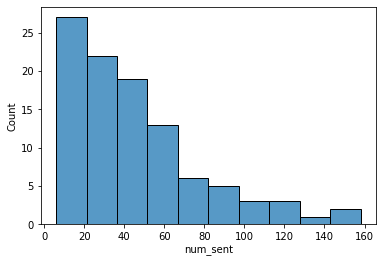

In [89]:
sns.histplot(d_drop.num_sent)

In [14]:
d_drop = d[d.r < 0.3]
d_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 8534 to 90287
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      10 non-null     object 
 1   src     10 non-null     object 
 2   dst     10 non-null     object 
 3   l_src   10 non-null     int64  
 4   l_dst   10 non-null     int64  
 5   r       10 non-null     float64
dtypes: float64(1), int64(2), object(3)
memory usage: 560.0+ bytes


In [21]:
def show():
    for i in range(10):
        print(d_drop.iloc[i,1], d_drop.iloc[i,2], sep='\n\n\n')
        yield

p = show()

## check those reasonable samples

In [94]:
prep = Preprocessor('bert-base-chinese')

In [95]:
d_filtered['num_src_sent'] = d_filtered.src.apply(lambda x: len(prep.cut_doc(x)))

/home/yuanhang/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [96]:
d_filtered['num_sdst_sent'] = d_filtered.dst.apply(lambda x: len(prep.cut_doc(x)))

/home/yuanhang/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [102]:
d_filtered['r_sent'] = d_filtered.num_sdst_sent/d_filtered.num_src_sent

/home/yuanhang/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [103]:
d_filtered.r_sent.quantile([0.1*i for i in range(10)])

0.0    0.018182
0.1    0.687500
0.2    0.888889
0.3    1.000000
0.4    1.125000
0.5    1.243243
0.6    1.372093
0.7    1.538462
0.8    1.800000
0.9    2.285714
Name: r_sent, dtype: float64

## check those with high r_sent


In [104]:
d_sent = d_filtered[d_filtered.r_sent > 2]

In [110]:
print(d_sent.iloc[132,1],d_sent.iloc[132,2], sep='\n\n')

五本近期完结的精品小说，口碑极好爽点十足，总字数超过千万大家好，我是冬日暖阳，今天给大家带来的是，五本近期完结的精品小说，口碑极好爽点十足，总字数超千万！ 
 
《天降我才必有用》作者：石章鱼 
总字数：351万字 
石章鱼真的是阐述了“柳暗花明又一村”是什么感觉，当年在被封得一书不剩的情况下，发布了《医统天下》，结果这本在他还没有完全准备，也并不是很想写的书，不仅火了，还顺利卖出了版权，据说电视剧也早已经杀青。 
这本《天降我才必有用》是他精心准备，并且想极力表现自己的书，却没想到，根本没有达到自己预期的成绩。我觉得吧，有时候就是这样，你用心去做一件事情的时候，你就会觉得束手束脚，当你啥都不在乎，凭着自己内心走的时候，一切就变得顺畅了很多。 
新书《骨舟记》也有十五万字了，书荒的朋友 也可以去看看，这是一本充满悬疑的仙侠类小说，喜欢这类型的就别错过了。 
 
《最强孝心系统》 
总字数：71万字 
本书的作者名字叫做打死不鸽，却没想到本书并没有按照作者的名字来，在七十一万字的时候就被迫完结，就是可惜了一本好书。本书的设定非常有意思，就是题材选错了，因为题材的问题被屏蔽过一次，结果刚出来就匆匆完结了。 
遗憾肯定是有的，就是希望作者能够收拾好自己的心情，重头再来。 
《沧元图》作者：我吃西红柿 
总字数：192万字 
番茄就是一个闷声发大财的一个作者，别看他的这本新书，没有经常在各大榜单的前面，但也是在前十徘徊，这样一个 月的收入也是不容小觑的哦，更别说，他老书的收入，尤其是《吞噬星空》，这本小说因为动漫的播出，屡屡居于榜单前面让众多作者羡慕不已。 
 
《鬼神竟是我自己》作者：剪水II 
每次看到这个书名的时候，我都会笑笑，实在是有趣极了，只可惜这本书在五十万字的时候就选择挥刀自宫了。原本是等着养肥的，结果没想到羊儿提前夭折了。据作者自己说，是他本身抑郁得太厉害，原本结局都有了，实在是写不下去了，才选择完结的。不过，此书还是拿到了精品的，前期的质量还是不错，喜欢这类搞笑风的还是可以试试。 
《证道从遮天开始》作者：鬼灯青月 
总字数：343万字 
这是一本从穿到遮天开始的无限流小说，成绩是非常不错，本书让作者 一书到了五级，看到这里是不是觉得非常惊讶，这可是一个新人作者，能够有如此的成绩着实厉害，而他书中的剧情也是值得让人去品读。 
 
好了，这次推荐就到此结束了

In [35]:
def to_dict(id,src,dst):
    return {
        'id':id,
        'src':src,
        'dst':dst
    }
    
with open(f_path,'w') as f:
    n = d_filtered.shape[0]
    for i in range(n):
        json.dump(
            to_dict(d_filtered.iloc[i,0], d_filtered.iloc[i,1], d_filtered.iloc[i,2]),
            f
        )
        f.write('\n')


## check final dataset


In [36]:
d = read_json_to_dataframe(f_path)
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90427 entries, 0 to 90426
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      90427 non-null  object
 1   src     90427 non-null  object
 2   dst     90427 non-null  object
dtypes: object(3)
memory usage: 2.1+ MB


## match WC


In [39]:
wc_path = 'data/train/train_wc.csv'
wc = pd.read_csv(wc_path)

In [40]:
wc_filtered = wc[wc.id.isin(d.id)]
wc_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90427 entries, 0 to 553453
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   90427 non-null  object 
 1   title_num_char       90427 non-null  int64  
 2   title_num_word       90427 non-null  int64  
 3   title_num_keyword    90427 non-null  int64  
 4   num_char             90427 non-null  int64  
 5   num_char_del_stop    90427 non-null  int64  
 6   num_uni_char         90427 non-null  int64  
 7   num_punc             90427 non-null  int64  
 8   num_word             90427 non-null  int64  
 9   num_uni_word         90427 non-null  int64  
 10  num_noun             90427 non-null  int64  
 11  num_adj              90427 non-null  int64  
 12  num_verb             90427 non-null  int64  
 13  num_adv              90427 non-null  int64  
 14  num_conj             90427 non-null  int64  
 15  num_numeral          90427 non-null

In [43]:
back_trans_wc_path = 'data/train/back_trans_wc.csv'
wc_filtered.to_csv(back_trans_wc_path, index = False, header = True)

## check wc


In [44]:
wc = pd.read_csv(back_trans_wc_path)
wc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90427 entries, 0 to 90426
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   90427 non-null  object 
 1   title_num_char       90427 non-null  int64  
 2   title_num_word       90427 non-null  int64  
 3   title_num_keyword    90427 non-null  int64  
 4   num_char             90427 non-null  int64  
 5   num_char_del_stop    90427 non-null  int64  
 6   num_uni_char         90427 non-null  int64  
 7   num_punc             90427 non-null  int64  
 8   num_word             90427 non-null  int64  
 9   num_uni_word         90427 non-null  int64  
 10  num_noun             90427 non-null  int64  
 11  num_adj              90427 non-null  int64  
 12  num_verb             90427 non-null  int64  
 13  num_adv              90427 non-null  int64  
 14  num_conj             90427 non-null  int64  
 15  num_numeral          90427 non-null 

## split debug set


In [45]:
debug_path = 'data/debug/debug_set.csv'
de = pd.read_csv(debug_path)
de.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   256 non-null    object 
 1   title                256 non-null    object 
 2   body                 256 non-null    object 
 3   category             256 non-null    float64
 4   title_num_char       256 non-null    float64
 5   title_num_word       256 non-null    float64
 6   title_num_keyword    256 non-null    float64
 7   num_char             256 non-null    float64
 8   num_char_del_stop    256 non-null    float64
 9   num_uni_char         256 non-null    float64
 10  num_punc             256 non-null    float64
 11  num_word             256 non-null    float64
 12  num_uni_word         256 non-null    float64
 13  num_noun             256 non-null    float64
 14  num_adj              256 non-null    float64
 15  num_verb             256 non-null    flo

In [49]:
json_path = 'data/debug/corpus.json' 
json_names = ['id','title','body','category','doctype']
def to_dict(s):
    return {
        'id':s.id,
        'title':s.title,
        'body':s.body,
        'category':s.category,
        'doctype':s.doctype
    }
    
with open(json_path,'w') as f:
    n = de.shape[0]
    for i in range(n):
        json.dump(to_dict(de.iloc[i]), f)
        f.write('\n')

In [50]:
json_path = 'data/debug/corpus.json' 
d = read_json_to_dataframe(json_path)
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        256 non-null    object 
 1   title     256 non-null    object 
 2   body      256 non-null    object 
 3   category  256 non-null    float64
 4   doctype   256 non-null    object 
dtypes: float64(1), object(4)
memory usage: 10.1+ KB


In [51]:
de_wc = de.iloc[:,[0]+[i for i in range(4,32)]]
de_wc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   256 non-null    object 
 1   title_num_char       256 non-null    float64
 2   title_num_word       256 non-null    float64
 3   title_num_keyword    256 non-null    float64
 4   num_char             256 non-null    float64
 5   num_char_del_stop    256 non-null    float64
 6   num_uni_char         256 non-null    float64
 7   num_punc             256 non-null    float64
 8   num_word             256 non-null    float64
 9   num_uni_word         256 non-null    float64
 10  num_noun             256 non-null    float64
 11  num_adj              256 non-null    float64
 12  num_verb             256 non-null    float64
 13  num_adv              256 non-null    float64
 14  num_conj             256 non-null    float64
 15  num_numeral          256 non-null    flo

In [52]:
wc_path = 'data/debug/wc.csv'
de_wc.to_csv(wc_path, index=False,header=True)

## filter labeled samples

In [2]:
p = 'data/doc_data_quality_train.json'
df = read_json_to_dataframe(p)
df.info()

576454it [00:22, 25964.63it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576454 entries, 0 to 576453
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        576454 non-null  object
 1   title     576454 non-null  object
 2   body      576454 non-null  object
 3   category  576454 non-null  int64 
 4   doctype   576454 non-null  object
dtypes: int64(1), object(4)
memory usage: 22.0+ MB


In [3]:
df = df[df.doctype != '']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76454 entries, 500000 to 576453
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        76454 non-null  object
 1   title     76454 non-null  object
 2   body      76454 non-null  object
 3   category  76454 non-null  int64 
 4   doctype   76454 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.5+ MB


In [4]:
write_dataframe_to_json(df, p)

 96%|█████████▋| 73734/76454 [00:35<00:01, 2553.88it/s]

In [ ]:
p = 'data/train/train_corpus.json'
df = read_json_to_dataframe(p)
df.info()